In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV as GSCV
from dask_searchcv import GridSearchCV as DGSCV

#from sklearn.tree import export_graphviz
#from IPython.display import Image

C:\CS\Anaconda\envs\DublinBus\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# setting variables
cores = 3
SSIDno = 12881289

time: 1e+03 µs


##  Reading in the data and preparing the SSID dataframe

In [3]:
res = pd.read_csv('Route_XXXX_travel_time_csvs/Route_016C_travel_time.csv')
route_list_SSID12881289 = ['0016', '0068', '0122', '0009', '068A']
for r in route_list_SSID12881289:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 
res

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed
0,Tuesday,1278,8,068A0001,0.0,44951278,False,4495,2012-11-06,18,1909,15.0
1,Tuesday,1282,8,068A0001,0.0,12781282,False,1278,2012-11-06,19,1909,15.0
2,Tuesday,4456,8,068A0001,0.0,12824456,False,1282,2012-11-06,41,1909,15.0
3,Tuesday,1284,8,068A0001,0.0,44561284,False,4456,2012-11-06,62,1909,15.0
4,Tuesday,1285,8,068A0001,0.0,12841285,False,1284,2012-11-06,297,1909,15.0
5,Tuesday,1286,8,068A0001,0.0,12851286,False,1285,2012-11-06,181,1909,15.0
6,Tuesday,1288,8,068A0001,0.0,12861288,False,1286,2012-11-06,72,1909,15.0
7,Tuesday,1289,8,068A0001,0.0,12881289,False,1288,2012-11-06,37,1909,15.0
8,Tuesday,1360,9,068A0001,0.0,12891360,False,1289,2012-11-06,114,1909,15.5
9,Tuesday,1362,9,068A0001,0.0,13601362,False,1360,2012-11-06,39,1909,15.5


time: 2.48 s


In [4]:
res.shape

(1325620, 12)

time: 2 ms


In [5]:
#check unique values of each feature

print("Feature, UniqueValues") 
for column in res:
    print(column + "\t" + str(len(res[column].unique())))

Feature, UniqueValues
Day	7
DestStopID	482
HourFrame	19
JourneyPatternID	28
Rain	125
SSID	3144
SchoolHoliday	2
SourceStopID	481
TimeFrame	57
TravelTime	1445
VehicleJourneyID	3304
WindSpeed	58
time: 228 ms


Description:  This segment is on Leeson Street, going into the city centre, just before the turn off to drive around Stephens Green.

In [6]:
# create dataframe for SSID

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno] 
ssid_df.shape

(10619, 12)

time: 167 ms


In [7]:
#check unique values of each feature

print("Feature, UniqueValues") 
for column in ssid_df:
    print(column + "\t" + str(len(ssid_df[column].unique())))

Feature, UniqueValues
Day	7
DestStopID	1
HourFrame	19
JourneyPatternID	11
Rain	122
SSID	1
SchoolHoliday	2
SourceStopID	1
TimeFrame	56
TravelTime	142
VehicleJourneyID	1731
WindSpeed	58
time: 10 ms


In [8]:
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.memory_usage(deep=True)

Index                   80
Day                 682069
DestStopID           84952
HourFrame            84952
JourneyPatternID    388287
Rain                 84952
SSID                128310
SchoolHoliday        10619
SourceStopID         84952
TimeFrame           711473
TravelTime           84952
VehicleJourneyID     84952
WindSpeed            84952
dtype: int64

time: 10 ms


In [9]:
ssid_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10619 entries, 0 to 10618
Data columns (total 12 columns):
Day                 10619 non-null object
DestStopID          10619 non-null int64
HourFrame           10619 non-null int64
JourneyPatternID    10619 non-null object
Rain                10619 non-null float64
SSID                10619 non-null category
SchoolHoliday       10619 non-null bool
SourceStopID        10619 non-null int64
TimeFrame           10619 non-null object
TravelTime          10619 non-null int64
VehicleJourneyID    10619 non-null int64
WindSpeed           10619 non-null float64
dtypes: bool(1), category(1), float64(2), int64(5), object(3)
memory usage: 2.4 MB
time: 11 ms


In [10]:
ssid_df['JourneyPatternID'] = ssid_df['JourneyPatternID'].astype('object')

time: 4 ms


In [11]:
ssid_df

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed
0,Tuesday,1289,8,068A0001,0.000000,12881289,False,1288,2012-11-06,37,1909,15.0
1,Tuesday,1289,10,068A0001,0.000000,12881289,False,1288,2012-11-06,20,1911,16.5
2,Tuesday,1289,15,068A0001,0.000000,12881289,False,1288,2012-11-06,79,1912,16.5
3,Tuesday,1289,17,068A0001,0.000000,12881289,False,1288,2012-11-06,60,2080,14.0
4,Tuesday,1289,18,068A0001,0.000000,12881289,False,1288,2012-11-06,43,2081,14.0
5,Wednesday,1289,10,068A0001,0.000000,12881289,False,1288,2012-11-07,21,1911,16.5
6,Wednesday,1289,15,068A0001,0.000000,12881289,False,1288,2012-11-07,40,1912,15.0
7,Wednesday,1289,16,068A0001,0.000000,12881289,False,1288,2012-11-07,98,1913,16.5
8,Wednesday,1289,17,068A0001,0.033333,12881289,False,1288,2012-11-07,57,2080,18.0
9,Wednesday,1289,18,068A0001,0.033333,12881289,False,1288,2012-11-07,43,2081,16.0


time: 39 ms


In [12]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

ssid_df.head(10)

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed,XBuses
0,Tuesday,1289,8,068A0001,0.000000,12881289,False,1288,2012-11-06,37,1909,15.0,0
1,Tuesday,1289,10,068A0001,0.000000,12881289,False,1288,2012-11-06,20,1911,16.5,0
2,Tuesday,1289,15,068A0001,0.000000,12881289,False,1288,2012-11-06,79,1912,16.5,0
3,Tuesday,1289,17,068A0001,0.000000,12881289,False,1288,2012-11-06,60,2080,14.0,0
4,Tuesday,1289,18,068A0001,0.000000,12881289,False,1288,2012-11-06,43,2081,14.0,0
5,Wednesday,1289,10,068A0001,0.000000,12881289,False,1288,2012-11-07,21,1911,16.5,0
6,Wednesday,1289,15,068A0001,0.000000,12881289,False,1288,2012-11-07,40,1912,15.0,0
7,Wednesday,1289,16,068A0001,0.000000,12881289,False,1288,2012-11-07,98,1913,16.5,0
8,Wednesday,1289,17,068A0001,0.033333,12881289,False,1288,2012-11-07,57,2080,18.0,0
9,Wednesday,1289,18,068A0001,0.033333,12881289,False,1288,2012-11-07,43,2081,16.0,0


time: 36 ms


In [13]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL

,Unnamed: 0,JourneyPatternID,JPID_length
0,58,00010001,42
1,97,00010002,21
2,110,00011001,42
3,152,00011002,23
4,167,00040001,60
5,296,00070001,67
6,335,00070002,66
7,410,00080001,46
8,421,00081001,51
9,429,00090001,66


time: 15 ms


In [14]:
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
# ssid_df['JourneyPatternID'] = ssid_df['JourneyPatternID'].astype('category')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed,XBuses,JPID_length
0,Tuesday,1289,8,068A0001,0.000000,12881289,False,1288,2012-11-06,37,1909,15.0,0,23
1,Tuesday,1289,10,068A0001,0.000000,12881289,False,1288,2012-11-06,20,1911,16.5,0,23
2,Tuesday,1289,15,068A0001,0.000000,12881289,False,1288,2012-11-06,79,1912,16.5,0,23
3,Tuesday,1289,17,068A0001,0.000000,12881289,False,1288,2012-11-06,60,2080,14.0,0,23
4,Tuesday,1289,18,068A0001,0.000000,12881289,False,1288,2012-11-06,43,2081,14.0,0,23
5,Wednesday,1289,10,068A0001,0.000000,12881289,False,1288,2012-11-07,21,1911,16.5,0,23
6,Wednesday,1289,15,068A0001,0.000000,12881289,False,1288,2012-11-07,40,1912,15.0,0,23
7,Wednesday,1289,16,068A0001,0.000000,12881289,False,1288,2012-11-07,98,1913,16.5,0,23
8,Wednesday,1289,17,068A0001,0.033333,12881289,False,1288,2012-11-07,57,2080,18.0,0,23
9,Wednesday,1289,18,068A0001,0.033333,12881289,False,1288,2012-11-07,43,2081,16.0,0,23


time: 76 ms


In [15]:
ssid_df.shape

(10619, 14)

time: 3 ms


In [16]:
# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')
ssid_df

,Day,DestStopID,HourFrame,JourneyPatternID,Rain,SSID,SchoolHoliday,SourceStopID,TimeFrame,TravelTime,VehicleJourneyID,WindSpeed,XBuses,JPID_length,JPID_Freq
0,Tuesday,1289,8,068A0001,0.000000,12881289,False,1288,2012-11-06,37,1909,15.0,0,23,207
1,Tuesday,1289,10,068A0001,0.000000,12881289,False,1288,2012-11-06,20,1911,16.5,0,23,207
2,Tuesday,1289,15,068A0001,0.000000,12881289,False,1288,2012-11-06,79,1912,16.5,0,23,207
3,Tuesday,1289,17,068A0001,0.000000,12881289,False,1288,2012-11-06,60,2080,14.0,0,23,207
4,Tuesday,1289,18,068A0001,0.000000,12881289,False,1288,2012-11-06,43,2081,14.0,0,23,207
5,Wednesday,1289,10,068A0001,0.000000,12881289,False,1288,2012-11-07,21,1911,16.5,0,23,207
6,Wednesday,1289,15,068A0001,0.000000,12881289,False,1288,2012-11-07,40,1912,15.0,0,23,207
7,Wednesday,1289,16,068A0001,0.000000,12881289,False,1288,2012-11-07,98,1913,16.5,0,23,207
8,Wednesday,1289,17,068A0001,0.033333,12881289,False,1288,2012-11-07,57,2080,18.0,0,23,207
9,Wednesday,1289,18,068A0001,0.033333,12881289,False,1288,2012-11-07,43,2081,16.0,0,23,207


time: 50 ms


In [17]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 3 ms


In [18]:
ssid_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10619 entries, 0 to 10618
Data columns (total 15 columns):
Day                 10619 non-null object
DestStopID          10619 non-null int64
HourFrame           10619 non-null int64
JourneyPatternID    10619 non-null object
Rain                10619 non-null float64
SSID                10619 non-null category
SchoolHoliday       10619 non-null int32
SourceStopID        10619 non-null int64
TimeFrame           10619 non-null object
TravelTime          10619 non-null int64
VehicleJourneyID    10619 non-null int64
WindSpeed           10619 non-null float64
XBuses              10619 non-null int32
JPID_length         10619 non-null int64
JPID_Freq           10619 non-null int64
dtypes: category(1), float64(2), int32(2), int64(7), object(3)
memory usage: 3.0 MB
time: 12 ms


In [19]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 20 ms


In [20]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

time: 1e+03 µs


In [21]:
# reorder remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'JPID_Freq', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 3 ms


In [22]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,Day,HourFrame
0,37,0.000000,15.0,23,207,0,0,Tuesday,8
1,20,0.000000,16.5,23,207,0,0,Tuesday,10
2,79,0.000000,16.5,23,207,0,0,Tuesday,15
3,60,0.000000,14.0,23,207,0,0,Tuesday,17
4,43,0.000000,14.0,23,207,0,0,Tuesday,18
5,21,0.000000,16.5,23,207,0,0,Wednesday,10
6,40,0.000000,15.0,23,207,0,0,Wednesday,15
7,98,0.000000,16.5,23,207,0,0,Wednesday,16
8,57,0.033333,18.0,23,207,0,0,Wednesday,17
9,43,0.033333,16.0,23,207,0,0,Wednesday,18


time: 39 ms


In [23]:
ssid_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10619 entries, 0 to 10618
Data columns (total 9 columns):
TravelTime       10619 non-null int64
Rain             10619 non-null float64
WindSpeed        10619 non-null float64
JPID_length      10619 non-null int64
JPID_Freq        10619 non-null int64
XBuses           10619 non-null int32
SchoolHoliday    10619 non-null int32
Day              10619 non-null object
HourFrame        10619 non-null int64
dtypes: float64(2), int32(2), int64(4), object(1)
memory usage: 1.6 MB
time: 7 ms


In [24]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 38 ms


In [25]:
# save as csv


ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 93 ms


## Analysis of target feature TravelTime

Histiogram of values (x-axis is number of seconds)

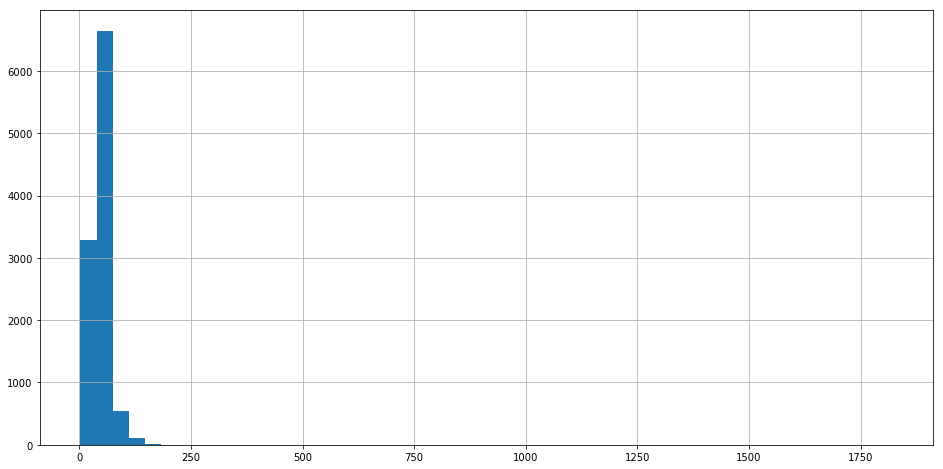

time: 290 ms


In [26]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

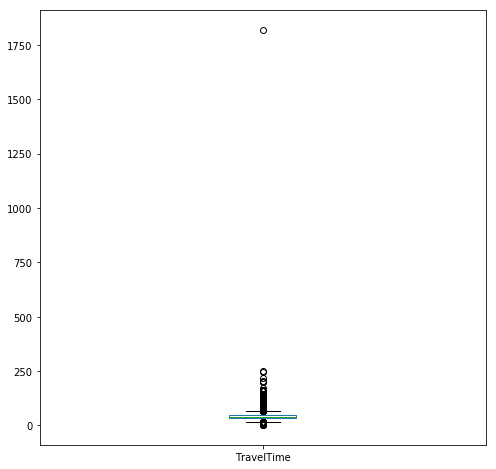

time: 238 ms


In [27]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [28]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    10619.000000
mean        42.558245
std         26.245258
min          2.000000
25%         35.000000
50%         40.000000
75%         48.000000
max       1820.000000
Name: TravelTime, dtype: float64

time: 5 ms


## Dropping outliers

In [29]:
# loading table of times to traverse segments at 80kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == 9090786, 'min_sec'].iloc[0]
print(lb)

14.5378563877
time: 15 ms


In [30]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond a conservative 2 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (2*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 715 outliers dropped.
time: 18 ms


In [31]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,Day,HourFrame
0,74,0.000000,17.0,53,2835,0,0,Wednesday,12
1,74,0.000000,12.0,66,3077,0,0,Friday,16
2,74,0.000000,10.5,76,3176,0,0,Thursday,15
3,74,0.000000,11.5,66,3077,0,0,Friday,17
4,74,0.000000,6.5,66,3077,0,0,Wednesday,7
5,74,0.000000,9.5,66,3077,0,0,Thursday,19
6,74,0.000000,3.0,53,2835,0,0,Wednesday,19
7,74,0.000000,3.5,53,2835,0,0,Saturday,15
8,74,0.000000,24.0,66,3077,0,0,Monday,15
9,74,0.266602,11.5,66,3077,0,0,Tuesday,8


time: 99 ms


In [32]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage error scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    9904.000000
mean       38.977181
std        13.594831
min        15.000000
25%        27.000000
50%        39.000000
75%        42.000000
max        74.000000
Name: TravelTime, dtype: float64

time: 9 ms


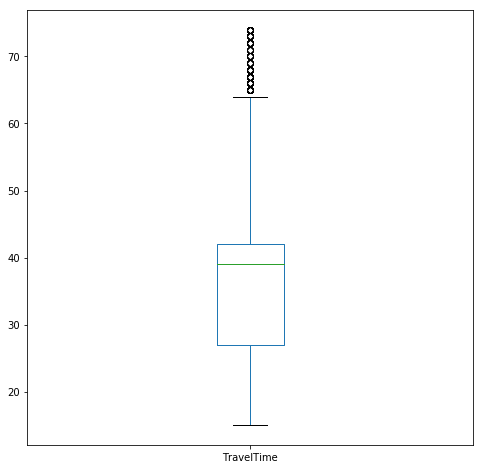

time: 184 ms


In [33]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## Visualising the data

### 1a Bar plot for mean TravelTime per HourFrame

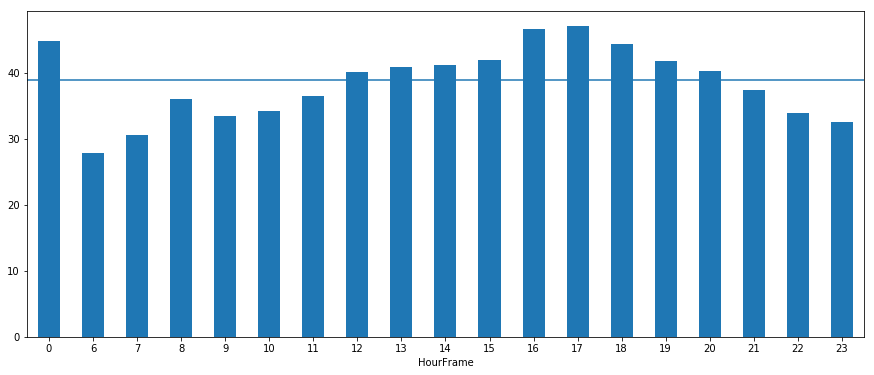

time: 205 ms


In [34]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 1b Bar plot for median TravelTime per HourFrame

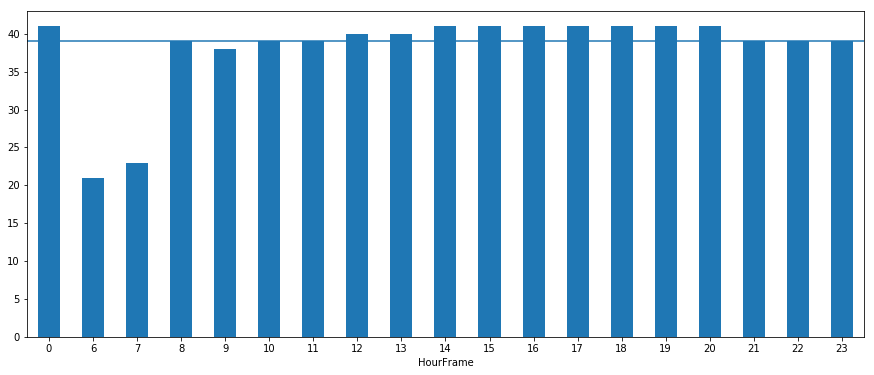

time: 230 ms


In [35]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

### 2a Bar plot for mean TravelTime per Day

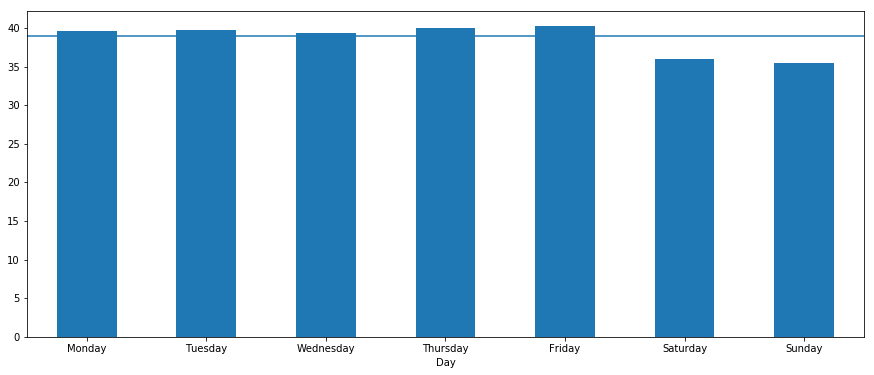

time: 152 ms


In [36]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2b Bar plot for median TravelTime per HourFrame

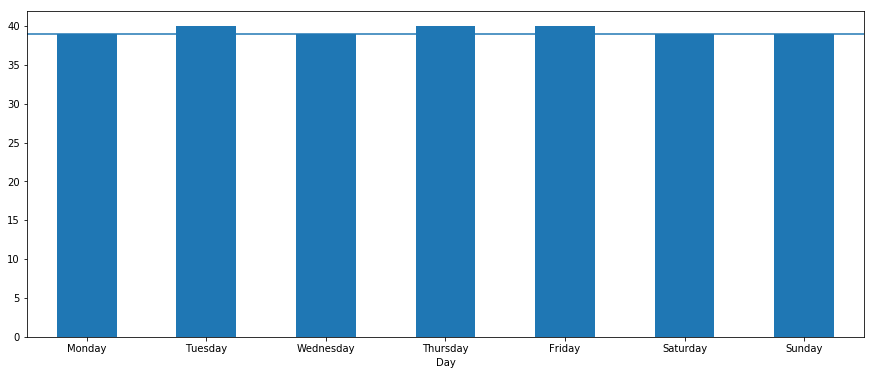

time: 151 ms


In [37]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

### 3a Bar plot for mean TravelTime when SchoolHoliday true/false

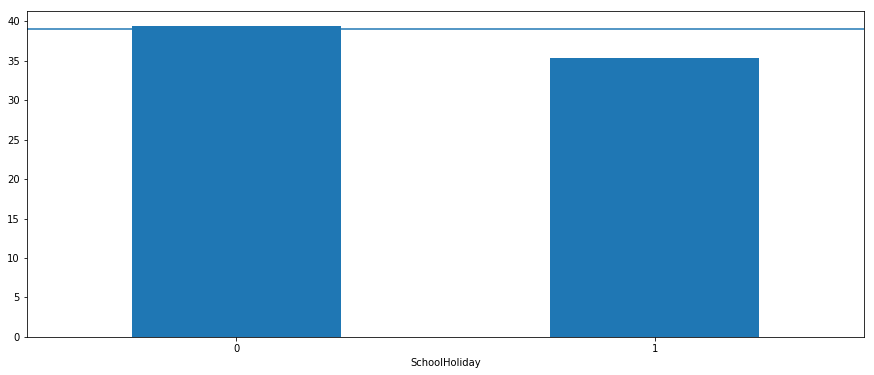

time: 136 ms


In [38]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 3b Bar plot for median TravelTime when SchoolHoliday true/false

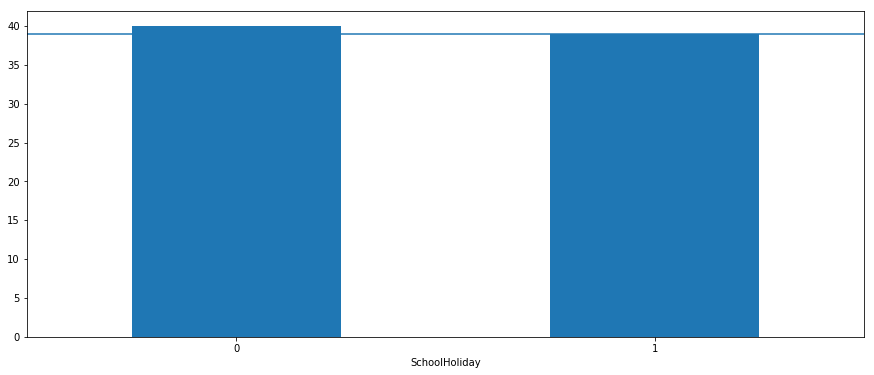

time: 187 ms


In [39]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

## Model training (statsmodels)

### 1a. Linear Regression model (via statsmodels - to see p-values)

Splitting data into 70% for training and 30% for testing

In [40]:
# Code to split data taken from here: http://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas

ssid_train=ssid_df.sample(frac=0.7, random_state=38)
ssid_test=ssid_df.drop(ssid_train.index)
print ("Training set size is",len(ssid_train))
print ("Testing set size is",len(ssid_test))

Training set size is 6933
Testing set size is 2971
time: 6 ms


In [41]:
lrle = sm.ols(formula="TravelTime ~ SchoolHoliday + WindSpeed + Rain + JPID_length + JPID_Freq + XBuses + C(HourFrame) + C(Day)", data=ssid_train).fit()

time: 4.94 s


In [42]:
print(lrle.summary())

                            OLS Regression Results                            
Dep. Variable:             TravelTime   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     46.23
Date:                Fri, 25 Aug 2017   Prob (F-statistic):          5.43e-240
Time:                        04:41:50   Log-Likelihood:                -27327.
No. Observations:                6933   AIC:                         5.471e+04
Df Residuals:                    6903   BIC:                         5.492e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              47.3790    

C:\CS\Anaconda\envs\DublinBus\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [43]:
# repeat on test frame and return Adj. R-squared value

#rsqa = stm.regression.linear_model.RegressionResults.rsquared_adj(lrle.predict(ssid_lin_test))
#print ("The predicted adjusted R-squared value on the test frame is", rsqa)

time: 1 ms


### 1b. Repeat Linear Regression model via statsmodels with continuous features normalised

We need to normalise the relevant parts of the original data and then repeat the test/train split

In [44]:
# Normalising continuous features

ssid_lin = ssid_df
ssid_lin['WindSpeed'] = (ssid_lin['WindSpeed']-ssid_lin['WindSpeed'].min())/(ssid_lin['WindSpeed'].max()-ssid_lin['WindSpeed'].min())
ssid_lin['Rain'] = (ssid_lin['Rain']-ssid_lin['Rain'].min())/(ssid_lin['Rain'].max()-ssid_lin['Rain'].min())
ssid_lin['JPID_length'] = (ssid_lin['JPID_length']-ssid_lin['JPID_length'].min())/(ssid_lin['JPID_length'].max()-ssid_lin['JPID_length'].min())
ssid_lin['JPID_Freq'] = (ssid_lin['JPID_Freq']-ssid_lin['JPID_Freq'].min())/(ssid_lin['JPID_Freq'].max()-ssid_lin['JPID_Freq'].min())
ssid_lin

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,Day,HourFrame
0,74,0.000000,0.542373,0.566038,0.891297,0,0,Wednesday,12
1,74,0.000000,0.372881,0.811321,0.968441,0,0,Friday,16
2,74,0.000000,0.322034,1.000000,1.000000,0,0,Thursday,15
3,74,0.000000,0.355932,0.811321,0.968441,0,0,Friday,17
4,74,0.000000,0.186441,0.811321,0.968441,0,0,Wednesday,7
5,74,0.000000,0.288136,0.811321,0.968441,0,0,Thursday,19
6,74,0.000000,0.067797,0.566038,0.891297,0,0,Wednesday,19
7,74,0.000000,0.084746,0.566038,0.891297,0,0,Saturday,15
8,74,0.000000,0.779661,0.811321,0.968441,0,0,Monday,15
9,74,0.058380,0.355932,0.811321,0.968441,0,0,Tuesday,8


time: 71 ms


In [45]:
ssid_lin_train=ssid_lin.sample(frac=0.7, random_state=38)
ssid_lin_test=ssid_lin.drop(ssid_lin_train.index)
print ("Training set size is",len(ssid_lin_train))
print ("Training set size is",len(ssid_lin_test))

Training set size is 6933
Training set size is 2971
time: 38 ms


In [46]:
lrle1 = sm.ols(formula="TravelTime ~ SchoolHoliday + WindSpeed + Rain + JPID_length + JPID_Freq + XBuses + C(HourFrame) + C(Day)", data=ssid_lin_train).fit()

time: 4.39 s


In [47]:
print(lrle1.summary())

                            OLS Regression Results                            
Dep. Variable:             TravelTime   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     46.23
Date:                Fri, 25 Aug 2017   Prob (F-statistic):          5.43e-240
Time:                        04:41:55   Log-Likelihood:                -27327.
No. Observations:                6933   AIC:                         5.471e+04
Df Residuals:                    6903   BIC:                         5.492e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              47.6858    

C:\CS\Anaconda\envs\DublinBus\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\CS\Anaconda\envs\DublinBus\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [48]:
# repeat on test frame and return Adj. R-squared value

# rsqa = stm.regression.linear_model.RegressionResults.rsquared_adj(lrle.predict(ssid_lin_test))
# print ("The predicted adjusted R-squared value on the test frame is", rsqa)

time: 1e+03 µs


## Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### Prepare data for modelling via Scikit-learn

In [49]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,HF_6,HF_7,HF_8,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,74,0.000000,0.542373,0.566038,0.891297,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,74,0.000000,0.372881,0.811321,0.968441,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,74,0.000000,0.322034,1.000000,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,74,0.000000,0.355932,0.811321,0.968441,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,74,0.000000,0.186441,0.811321,0.968441,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,74,0.000000,0.288136,0.811321,0.968441,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,74,0.000000,0.067797,0.566038,0.891297,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,74,0.000000,0.084746,0.566038,0.891297,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,74,0.000000,0.779661,0.811321,0.968441,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,74,0.058380,0.355932,0.811321,0.968441,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


time: 52 ms


In [50]:
# remove any constant features

selector = VarianceThreshold()
selector.fit_transform(ssid_df)

array([[  7.40000000e+01,   0.00000000e+00,   5.42372881e-01, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.40000000e+01,   0.00000000e+00,   3.72881356e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.40000000e+01,   0.00000000e+00,   3.22033898e-01, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.50000000e+01,   0.00000000e+00,   3.05084746e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.50000000e+01,   9.48905109e-02,   3.05084746e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.50000000e+01,   0.00000000e+00,   5.08474576e-02, ...,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

time: 10 ms


In [51]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'JPID_Freq', 'XBuses', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 2 ms


In [52]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [53]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 4 ms


### 1a Linear Regression model (via scikit-learn) - training - default parameters

In [54]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 2.84 s


In [55]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.170445376382
time: 18 ms


In [56]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 9.89896196783
The mean absolute percentage error is 25.3968135454
time: 5 ms


In [57]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 8.27405141246
The median absolute percentage error is 21.2155164422
time: 6 ms


### 1b Linear Regression model (via scikit-learn) - testing - default parameters

In [58]:
lr_preda = lr.predict(X_test)
lr_rsq = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.147791124625
time: 8 ms


In [59]:
lr_mae = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 10.0891061277
The mean absolute percentage error is 25.8846481073
time: 4 ms


In [60]:
lr_mdae = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 8.48145275627
The median absolute percentage error is 21.7473147597
time: 4 ms


### 2.1a Support Vector Machine Regression with Linear Kernel model - training - default parameters

In [61]:
svr_lin = SVR(kernel='linear')
svr_lin.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 2.15 s


In [62]:
svr_lin_pred = svr_lin.predict(X_train)
svr_lin_rsq = metrics.r2_score(y_train, svr_lin_pred)
print ("The R-squared value of the SVR with Linear Kernel model is", svr_lin_rsq)

The R-squared value of the SVR with Linear Kernel model is 0.0969823190592
time: 1.2 s


In [63]:
svr_lin_mae = metrics.mean_absolute_error(y_train, svr_lin_pred)
print ("The mean absolute error of the SVR with Linear Kernel model is", svr_lin_mae)
print ("The mean absolute percentage error is", (((svr_lin_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Linear Kernel model is 9.51877361592
The mean absolute percentage error is 24.4214008994
time: 5 ms


In [64]:
svr_lin_mdae = metrics.median_absolute_error(y_train, svr_lin_pred)
print ("The median absolute error of the SVR with Linear Kernel model is", svr_lin_mdae)
print ("The median absolute percentage error is", (((svr_lin_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Linear Kernel model is 4.34592866679
The median absolute percentage error is 11.1434068379
time: 4 ms


### 2.1b Support Vector Machine Regression with Linear Kernel model - testing - default parameters

In [65]:
svr_lin_preda = svr_lin.predict(X_test)
svr_lin_rsq = metrics.r2_score(y_test, svr_lin_preda)
print ("The R-squared value of the SVR with Linear Kernel model is", svr_lin_rsq)

The R-squared value of the SVR with Linear Kernel model is 0.0747569219886
time: 601 ms


In [66]:
svr_lin_mae = metrics.mean_absolute_error(y_test, svr_lin_preda)
print ("The mean absolute error of the SVR with Linear Kernel model is", svr_lin_mae)
print ("The mean absolute percentage error is", (((svr_lin_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Linear Kernel model is 9.70466073136
The mean absolute percentage error is 24.8983135724
time: 8 ms


In [67]:
svr_lin_mdae = metrics.median_absolute_error(y_test, svr_lin_preda)
print ("The median absolute error of the SVR with Linear Kernel model is", svr_lin_mdae)
print ("The median absolute percentage error is", (((svr_lin_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Linear Kernel model is 4.85094951453
The median absolute percentage error is 12.4383320885
time: 7 ms


### 2.1c Repeat SVR with Linear Kernel model, continuous data normalised - training  - default parameters

First we have to normalise the relevant data

In [68]:
# Normalising continuous features

ssid_norm = ssid_df
ssid_norm['WindSpeed'] = (ssid_norm['WindSpeed']-ssid_norm['WindSpeed'].min())/(ssid_norm['WindSpeed'].max()-ssid_norm['WindSpeed'].min())
ssid_norm['Rain'] = (ssid_norm['Rain']-ssid_norm['Rain'].min())/(ssid_norm['Rain'].max()-ssid_norm['Rain'].min())
ssid_norm['JPID_length'] = (ssid_norm['JPID_length']-ssid_norm['JPID_length'].min())/(ssid_norm['JPID_length'].max()-ssid_norm['JPID_length'].min())
ssid_norm['JPID_Freq'] = (ssid_norm['JPID_Freq']-ssid_norm['JPID_Freq'].min())/(ssid_norm['JPID_Freq'].max()-ssid_norm['JPID_Freq'].min())
ssid_norm

,TravelTime,Rain,WindSpeed,JPID_length,JPID_Freq,XBuses,SchoolHoliday,HF_6,HF_7,HF_8,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,74,0.000000,0.542373,0.566038,0.891297,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,74,0.000000,0.372881,0.811321,0.968441,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,74,0.000000,0.322034,1.000000,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,74,0.000000,0.355932,0.811321,0.968441,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,74,0.000000,0.186441,0.811321,0.968441,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,74,0.000000,0.288136,0.811321,0.968441,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,74,0.000000,0.067797,0.566038,0.891297,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,74,0.000000,0.084746,0.566038,0.891297,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,74,0.000000,0.779661,0.811321,0.968441,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,74,0.058380,0.355932,0.811321,0.968441,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


time: 63 ms


In [69]:
# prepare a list containing all remaining features bar the target

pred_features = list(ssid_norm)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'JPID_Freq', 'XBuses', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 3 ms


In [70]:
# prepare farget/predictive feature variables for use in scikit-learn modelling

X_norm = ssid_norm[pred_features]
y_norm = ssid_norm['TravelTime']

time: 4 ms


In [71]:
# split the data into training portion (70%) and final testing potion (30%)

Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_norm, y_norm, test_size = 0.3, random_state = 38)

time: 4 ms


Now onto modelling

In [72]:
svrn_lin = SVR(kernel='linear')
svrn_lin.fit(Xn_train, yn_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 2.08 s


In [73]:
svrn_lin_pred = svrn_lin.predict(X_train)
svrn_lin_rsq = metrics.r2_score(yn_train, svrn_lin_pred)
print ("The R-squared value of the SVR with Linear Kernel model is", svrn_lin_rsq)

The R-squared value of the SVR with Linear Kernel model is 0.0969823190592
time: 1.3 s


In [74]:
svrn_lin_mae = metrics.mean_absolute_error(y_train, svr_lin_pred)
print ("The mean absolute error of the SVR with Linear Kernel model is", svrn_lin_mae)
print ("The mean absolute percentage error is", (((svrn_lin_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Linear Kernel model is 9.51877361592
The mean absolute percentage error is 24.4214008994
time: 3 ms


In [75]:
svrn_lin_mdae = metrics.median_absolute_error(y_train, svr_lin_pred)
print ("The median absolute error of the SVR with Linear Kernel model is", svrn_lin_mdae)
print ("The median absolute percentage error is", (((svrn_lin_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Linear Kernel model is 4.34592866679
The median absolute percentage error is 11.1434068379
time: 7 ms


### 2.1d Repeat SVR with Linear Kernel model, continuous data normalised - testing  - default parameters

In [76]:
svrn_lin_preda = svrn_lin.predict(Xn_test)
svrn_lin_rsq = metrics.r2_score(yn_test, svrn_lin_preda)
print ("The R-squared value of the SVR with Linear Kernel model is", svr_lin_rsq)

The R-squared value of the SVR with Linear Kernel model is 0.0747569219886
time: 735 ms


In [77]:
svrn_lin_mae = metrics.mean_absolute_error(yn_test, svrn_lin_preda)
print ("The mean absolute error of the SVR with Linear Kernel model is", svr_lin_mae)
print ("The mean absolute percentage error is", (((svrn_lin_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Linear Kernel model is 9.70466073136
The mean absolute percentage error is 24.8983135724
time: 3 ms


In [78]:
svrn_lin_mdae = metrics.median_absolute_error(yn_test, svrn_lin_preda)
print ("The median absolute error of the SVR with Linear Kernel model is", svr_lin_mdae)
print ("The median absolute percentage error is", (((svrn_lin_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Linear Kernel model is 4.85094951453
The median absolute percentage error is 12.4383320885
time: 2.85 s


### 2.2a Support Vector Machine Regression with Polynomial Kernel model - training - default parameters

In [79]:
svr_poly = SVR(kernel='poly')
svr_poly.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 2.55 s


In [80]:
svr_poly_pred = svr_poly.predict(X_train)
svr_poly_rsq = metrics.r2_score(y_train, svr_poly_pred)
print ("The R-squared value of the SVR with Polynomial Kernel model is", svr_poly_rsq)

The R-squared value of the SVR with Polynomial Kernel model is 0.00323864970339
time: 1.51 s


In [81]:
svr_poly_mae = metrics.mean_absolute_error(y_train, svr_poly_pred)
print ("The mean absolute error of the SVR with Polynomial Kernel model is", svr_poly_mae)
print ("The mean absolute percentage error is", (((svr_poly_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Polynomial Kernel model is 9.82470263523
The mean absolute percentage error is 25.2062935262
time: 4 ms


In [82]:
svr_poly_mdae = metrics.median_absolute_error(y_train, svr_poly_pred)
print ("The median absolute error of the SVR with Polynomial Kernel model is", svr_poly_mdae)
print ("The median absolute percentage error is", (((svr_poly_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Polynomial Kernel model is 3.79395904345
The median absolute percentage error is 9.72810011142
time: 12 ms


### 2.2b Support Vector Machine Regression with Polynomial Kernel model - testing - default parameters

In [83]:
svr_poly_preda = svr_poly.predict(X_test)
svr_poly_rsq = metrics.r2_score(y_test, svr_poly_preda)
print ("The R-squared value of the SVR with Polynomial Kernel model is", svr_poly_rsq)

The R-squared value of the SVR with Polynomial Kernel model is 0.00329254945435
time: 683 ms


In [84]:
svr_poly_mae = metrics.mean_absolute_error(y_test, svr_poly_preda)
print ("The mean absolute error of the SVR with Polynomial Kernel model is", svr_poly_mae)
print ("The mean absolute percentage error is", (((svr_poly_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Polynomial Kernel model is 9.91875353008
The mean absolute percentage error is 25.4475908509
time: 3 ms


In [85]:
svr_poly_mdae = metrics.median_absolute_error(y_test, svr_poly_preda)
print ("The median absolute error of the SVR with Polynomial Kernel model is", svr_poly_mdae)
print ("The median absolute percentage error is", (((svr_poly_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Polynomial Kernel model is 3.83909432705
The median absolute percentage error is 9.84383160782
time: 7 ms


### 2.2c Repeat SVR with Polynomial Kernel model, continuous data normalised - training - default parameters

In [86]:
svrn_poly = SVR(kernel='poly')
svrn_poly.fit(Xn_train, yn_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 2.79 s


In [87]:
svrn_poly_pred = svrn_poly.predict(Xn_train)
svrn_poly_rsq = metrics.r2_score(yn_train, svrn_poly_pred)
print ("The R-squared value of the SVR with Polynomial Kernel model is", svrn_poly_rsq)

The R-squared value of the SVR with Polynomial Kernel model is 0.00323864970339
time: 1.56 s


In [88]:
svrn_poly_mae = metrics.mean_absolute_error(yn_train, svrn_poly_pred)
print ("The mean absolute error of the SVR with Polynomial Kernel model is", svrn_poly_mae)
print ("The mean absolute percentage error is", (((svrn_poly_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Polynomial Kernel model is 9.82470263523
The mean absolute percentage error is 25.2062935262
time: 4 ms


In [89]:
svrn_poly_mdae = metrics.median_absolute_error(yn_train, svrn_poly_pred)
print ("The median absolute error of the SVR with Polynomial Kernel model is", svrn_poly_mdae)
print ("The median absolute percentage error is", (((svrn_poly_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Polynomial Kernel model is 3.79395904345
The median absolute percentage error is 9.72810011142
time: 6 ms


### 2.2d Repeat SVR with Polynomial Kernel model, continuous data normalised - testing  - default parameters

In [90]:
svrn_poly_preda = svrn_poly.predict(Xn_test)
svrn_poly_rsq = metrics.r2_score(yn_test, svrn_poly_preda)
print ("The R-squared value of the SVR with Polynomial Kernel model is", svrn_poly_rsq)

The R-squared value of the SVR with Polynomial Kernel model is 0.00329254945435
time: 640 ms


In [91]:
svrn_poly_mae = metrics.mean_absolute_error(yn_test, svrn_poly_preda)
print ("The mean absolute error of the SVR with Polynomial Kernel model is", svrn_poly_mae)
print ("The mean absolute percentage error is", (((svrn_poly_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with Polynomial Kernel model is 9.91875353008
The mean absolute percentage error is 25.4475908509
time: 3 ms


In [92]:
svrn_poly_mdae = metrics.median_absolute_error(yn_test, svrn_poly_preda)
print ("The median absolute error of the SVR with Polynomial Kernel model is", svrn_poly_mdae)
print ("The median absolute percentage error is", (((svrn_poly_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with Polynomial Kernel model is 3.83909432705
The median absolute percentage error is 9.84383160782
time: 5 ms


### 2.3a Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [93]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 2.96 s


In [94]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.0668304326136
time: 2 s


In [95]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 9.60466269978
The mean absolute percentage error is 24.6417582516
time: 3 ms


In [96]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 3.84118287191
The median absolute percentage error is 9.84918685104
time: 7 ms


### 2.3b Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [97]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsq = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.0619747834693
time: 844 ms


In [98]:
svr_rbf_mae = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 9.70666010272
The mean absolute percentage error is 24.9034431669
time: 4 ms


In [99]:
svr_rbf_mdae = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 4.04451801339
The median absolute percentage error is 10.3705590087
time: 7 ms


### 2.3c Repeat SVR with RBF Kernel model, continuous data normalised - training  - default parameters

In [100]:
svrn_rbf = SVR(kernel='rbf')
svrn_rbf.fit(Xn_train, yn_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 3.08 s


In [101]:
svrn_rbf_pred = svrn_rbf.predict(Xn_train)
svrn_rbf_rsq = metrics.r2_score(yn_train, svrn_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svrn_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.0668304326136
time: 1.89 s


In [102]:
svrn_rbf_mae = metrics.mean_absolute_error(yn_train, svrn_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svrn_rbf_mae)
print ("The mean absolute percentage error is", (((svrn_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 9.60466269978
The mean absolute percentage error is 24.6417582516
time: 4 ms


In [103]:
svrn_rbf_mdae = metrics.median_absolute_error(yn_train, svrn_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svrn_rbf_mdae)
print ("The median absolute percentage error is", (((svrn_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 3.84118287191
The median absolute percentage error is 9.84918685104
time: 8 ms


### 2.3d Repeat SVR with RBF Kernel model, continuous data normalised - testing  - default parameters

In [104]:
svrn_rbf_preda = svrn_rbf.predict(Xn_test)
svrn_rbf_rsq = metrics.r2_score(yn_test, svrn_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svrn_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.0619747834693
time: 885 ms


In [105]:
svrn_rbf_mae = metrics.mean_absolute_error(yn_test, svrn_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svrn_rbf_mae)
print ("The mean absolute percentage error is", (((svrn_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 9.70666010272
The mean absolute percentage error is 24.9034431669
time: 3 ms


In [106]:
svrn_rbf_mdae = metrics.median_absolute_error(yn_test, svrn_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svrn_rbf_mdae)
print ("The median absolute percentage error is", (((svrn_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 4.04451801339
The median absolute percentage error is 10.3705590087
time: 7 ms


### 3a Decision Tree Regression model - training - default parameters

In [107]:
# code from here: https://gist.github.com/JustGlowing/fa2c0ac39415eb271db6

dtr = DTR()
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

time: 34 ms


#### Printing ranking of features by estimated predictive value for Decision Tree Regression

In [108]:
# code adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
indices = np.argsort(dtr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", dtr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.278922650384
JPID_Freq 	 0.106732658485
JPID_length 	 0.0832044724033
Rain 	 0.0777503690557
HF_17 	 0.0460961215853
HF_16 	 0.0376027842246
HF_18 	 0.0311034064726
SchoolHoliday 	 0.029772791582
Day_Tuesday 	 0.0281439953739
Day_Saturday 	 0.0278881624087
Day_Sunday 	 0.0270713297843
HF_7 	 0.02408687664
Day_Thursday 	 0.022957699406
Day_Wednesday 	 0.022597509739
HF_9 	 0.0190617084213
Day_Monday 	 0.0180457975575
HF_10 	 0.013481816462
HF_22 	 0.0133331377873
HF_8 	 0.0131356559763
HF_23 	 0.0108548871118
HF_19 	 0.00881339055581
HF_13 	 0.0087302131079
HF_12 	 0.00866768326916
HF_6 	 0.00757418855887
HF_14 	 0.00756548212265
HF_11 	 0.00755878294184
HF_21 	 0.00675033518658
HF_15 	 0.00673152890625
HF_20 	 0.0057645644897
XBuses 	 0.0
time: 35 ms


In [109]:
dtr_pred = dtr.predict(X_train)
dtr_rsq = metrics.r2_score(y_train, dtr_pred)
print ("The R-squared value of the Decision Tree Regression model is", dtr_rsq)

The R-squared value of the Decision Tree Regression model is 0.572013701711
time: 7 ms


In [110]:
dtr_mae = metrics.mean_absolute_error(y_train, dtr_pred)
print ("The mean absolute error of the Decision Tree Regression model is", dtr_mae)
print ("The mean absolute percentage error is", (((dtr_mae)/ssid_df_mean)*100))

The mean absolute error of the Decision Tree Regression model is 6.15237351047
The mean absolute percentage error is 15.784552301
time: 5 ms


In [111]:
dtr_mdae = metrics.median_absolute_error(y_train, dtr_pred)
print ("The median absolute error of the Decision Tree Regression model is", dtr_mdae)
print ("The median absolute percentage error is", (((dtr_mdae)/ssid_df_median)*100))

The median absolute error of the Decision Tree Regression model is 4.66666666667
The median absolute percentage error is 11.9658119658
time: 10 ms


### 3b Decision Tree Regression model - testing - default parameters

In [112]:
dtr_preda = dtr.predict(X_test)
dtr_rsq = metrics.r2_score(y_test, dtr_preda)
print ("The R-squared value of the Decision Tree Regression model is", dtr_rsq)

The R-squared value of the Decision Tree Regression model is -0.397739574708
time: 7 ms


In [113]:
dtr_mae = metrics.mean_absolute_error(y_test, dtr_preda)
print ("The mean absolute error of the Decision Tree Regression model is", dtr_mae)
print ("The mean absolute percentage error is", (((dtr_mae)/ssid_df_mean)*100))

The mean absolute error of the Decision Tree Regression model is 12.4543039266
The mean absolute percentage error is 31.952808354
time: 15 ms


In [114]:
dtr_mdae = metrics.median_absolute_error(y_test, dtr_preda)
print ("The median absolute error of the Decision Tree Regression model is", dtr_mdae)
print ("The median absolute percentage error is", (((dtr_mdae)/ssid_df_median)*100))

The median absolute error of the Decision Tree Regression model is 11.0
The median absolute percentage error is 28.2051282051
time: 7 ms


### 4a Decision Tree Regression with AdaBoost model - training - default parameters

In [115]:
abr = ABR()
abr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

time: 120 ms


In [116]:
indices = np.argsort(abr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", dtr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_Freq 	 0.106732658485
HF_7 	 0.02408687664
HF_17 	 0.0460961215853
HF_16 	 0.0376027842246
SchoolHoliday 	 0.029772791582
HF_9 	 0.0190617084213
HF_18 	 0.0311034064726
HF_22 	 0.0133331377873
Day_Saturday 	 0.0278881624087
Day_Sunday 	 0.0270713297843
HF_10 	 0.013481816462
HF_23 	 0.0108548871118
Rain 	 0.0777503690557
Day_Tuesday 	 0.0281439953739
WindSpeed 	 0.278922650384
HF_15 	 0.00673152890625
JPID_length 	 0.0832044724033
HF_6 	 0.00757418855887
Day_Monday 	 0.0180457975575
Day_Wednesday 	 0.022597509739
HF_11 	 0.00755878294184
HF_8 	 0.0131356559763
HF_12 	 0.00866768326916
HF_13 	 0.0087302131079
HF_19 	 0.00881339055581
XBuses 	 0.0
HF_20 	 0.0057645644897
HF_21 	 0.00675033518658
Day_Thursday 	 0.022957699406
HF_14 	 0.00756548212265
time: 34 ms


In [117]:
abr_pred = abr.predict(X_train)
abr_rsq = metrics.r2_score(y_train, abr_pred)
print ("The R-squared value of the Decision Tree Regression with AdaBoost model is", abr_rsq)

The R-squared value of the Decision Tree Regression with AdaBoost model is 0.0640023813513
time: 13 ms


In [118]:
abr_mae = metrics.mean_absolute_error(y_train, abr_pred)
print ("The mean absolute error of the Decision Tree Regression with AdaBoost model is", abr_mae)
print ("The mean absolute percentage error is", (((abr_mae)/ssid_df_mean)*100))

The mean absolute error of the Decision Tree Regression with AdaBoost model is 9.68757607706
The mean absolute percentage error is 24.8544811199
time: 3 ms


In [119]:
abr_mdae = metrics.median_absolute_error(y_train, abr_pred)
print ("The median absolute error of the Decision Tree Regression with AdaBoost model is", abr_mdae)
print ("The median absolute percentage error is", (((abr_mdae)/ssid_df_median)*100))

The median absolute error of the Decision Tree Regression with AdaBoost model is 4.22705397044
The median absolute percentage error is 10.8385999242
time: 6 ms


### 4b Decision Tree Regression with AdaBoost model - testing - default parameters

In [120]:
abr_preda = abr.predict(X_test)
abr_rsq = metrics.r2_score(y_test, abr_preda)
print ("The R-squared value of the Decision Tree Regression with AdaBoost model is", abr_rsq)

The R-squared value of the Decision Tree Regression with AdaBoost model is 0.0571396557435
time: 13 ms


In [121]:
abr_mae = metrics.mean_absolute_error(y_test, abr_preda)
print ("The mean absolute error of the Decision Tree Regression with AdaBoost model is", abr_mae)
print ("The mean absolute percentage error is", (((abr_mae)/ssid_df_mean)*100))

The mean absolute error of the Decision Tree Regression with AdaBoost model is 9.7910101595
The mean absolute percentage error is 25.1198519855
time: 3 ms


In [122]:
abr_mdae = metrics.median_absolute_error(y_test, abr_preda)
print ("The median absolute error of the Decision Tree Regression with AdaBoost model is", abr_mdae)
print ("The median absolute percentage error is", (((abr_mdae)/ssid_df_median)*100))

The median absolute error of the Decision Tree Regression with AdaBoost model is 4.53865479603
The median absolute percentage error is 11.6375764001
time: 7 ms


### 5a Gradient Boosting Regression model - training - default parameters

In [123]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 395 ms


In [124]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.132691929389
JPID_Freq 	 0.081338246292
Rain 	 0.0623943860465
Day_Sunday 	 0.0559810410435
HF_7 	 0.0548021826828
HF_9 	 0.0532554707206
HF_23 	 0.0464941160138
HF_10 	 0.0462831146695
HF_22 	 0.0447909495748
Day_Saturday 	 0.0443860019174
SchoolHoliday 	 0.0442696277785
HF_17 	 0.0388700933678
HF_16 	 0.0351161601433
HF_8 	 0.0324017153728
HF_6 	 0.031473451021
JPID_length 	 0.0306251739472
HF_11 	 0.0285851544769
HF_18 	 0.0273114513822
Day_Tuesday 	 0.0170861712061
HF_15 	 0.0166968835552
HF_21 	 0.0165560460576
HF_19 	 0.0122671721105
HF_14 	 0.0105008169043
HF_13 	 0.0101570271929
Day_Monday 	 0.00807265176649
HF_20 	 0.00594289197619
HF_12 	 0.00503861743965
Day_Wednesday 	 0.00333620879146
Day_Thursday 	 0.00327524715951
XBuses 	 0.0
time: 79 ms


In [125]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.207520463261
time: 12 ms


In [126]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 9.50011743509
The mean absolute percentage error is 24.3735365327
time: 5 ms


In [127]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 7.51098199825
The median absolute percentage error is 19.2589282006
time: 5 ms


### 5b Gradient Boosting Regression model - - testing - default parameters

In [128]:
gbr_preda = gbr.predict(X_test)
gbr_rsq = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.154736503811
time: 8 ms


In [129]:
gbr_mae = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 9.8833510886
The mean absolute percentage error is 25.3567622158
time: 6 ms


In [130]:
gbr_mdae = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 8.12157469202
The median absolute percentage error is 20.8245504924
time: 6 ms


### 6a Random Forest Regression model (all default) - training - default parameters

In [131]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 121 ms


In [132]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", dtr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.278922650384
JPID_Freq 	 0.106732658485
JPID_length 	 0.0832044724033
Rain 	 0.0777503690557
HF_17 	 0.0460961215853
HF_16 	 0.0376027842246
Day_Tuesday 	 0.0281439953739
Day_Wednesday 	 0.022597509739
SchoolHoliday 	 0.029772791582
Day_Thursday 	 0.022957699406
Day_Saturday 	 0.0278881624087
HF_7 	 0.02408687664
Day_Sunday 	 0.0270713297843
Day_Monday 	 0.0180457975575
HF_18 	 0.0311034064726
HF_9 	 0.0190617084213
HF_13 	 0.0087302131079
HF_10 	 0.013481816462
HF_19 	 0.00881339055581
HF_22 	 0.0133331377873
HF_12 	 0.00866768326916
HF_15 	 0.00673152890625
HF_8 	 0.0131356559763
HF_23 	 0.0108548871118
HF_14 	 0.00756548212265
HF_20 	 0.0057645644897
HF_11 	 0.00755878294184
HF_21 	 0.00675033518658
HF_6 	 0.00757418855887
XBuses 	 0.0
time: 109 ms


In [133]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.510660404598
time: 106 ms


In [134]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 7.17272496141
The mean absolute percentage error is 18.4023697686
time: 3 ms


In [135]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 5.7
The median absolute percentage error is 14.6153846154
time: 7 ms


### 6b Random Forest Regression model (all default) - testing - default parameters

In [136]:
rfr_preda = rfr.predict(X_test)
rfr_rsq = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is -0.129348447719
time: 106 ms


In [137]:
rfr_mae = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 11.4746820165
The mean absolute percentage error is 29.4394867476
time: 3 ms


In [138]:
rfr_mdae = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 9.90833333333
The median absolute percentage error is 25.405982906
time: 6 ms
